In [1]:
import torch 
from torch import nn
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score


In [2]:
NUM_CLASSES =4 
NUM_FEATURES=2
RANDMOM_SEED=42
X,y=make_blobs(n_samples=2000, n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDMOM_SEED)
X.shape,y.shape


((2000, 2), (2000,))

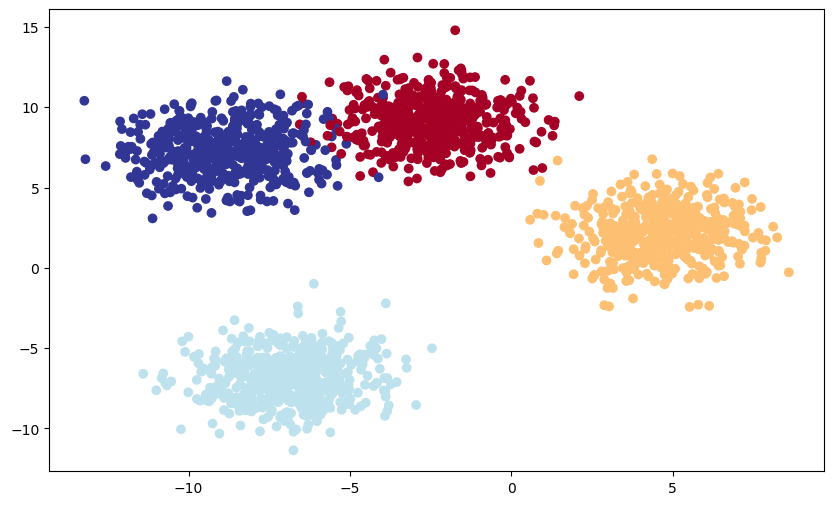

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],c=y,cmap='RdYlBu')

In [4]:
X,y=torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.float)
print(type(X))

<class 'torch.Tensor'>


In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.2)

In [6]:
class MultiClassClassifier(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=10):
        super().__init__()
        self.self_linear_layer_stack=nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(), 
            nn.Linear(in_features=hidden_units,out_features=output_features),
        )

    def forward(self,X): 
        return self.self_linear_layer_stack(X)
        
    

In [7]:
if torch.cuda.is_available():
    device='cuda'
elif torch.backends.mps.is_available(): 
    device=torch.device("mps")
else:
    device="cpu"

print(f"using device ={device}")

using device =cuda


In [8]:
model_1=MultiClassClassifier(input_features=2,output_features=4)


In [9]:
model_1.to(device)

MultiClassClassifier(
  (self_linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [10]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [11]:
model_1.eval()
with torch.inference_mode(): 
    y_logits=model_1(X_test.to(device))

y_logits[:10]

tensor([[ 0.2326,  1.4636,  0.2152, -0.2726],
        [ 1.6366,  0.2738,  1.5235, -1.5693],
        [ 0.7110,  2.8321,  0.9043, -1.2433],
        [ 1.7175,  0.3958,  1.7197, -1.7773],
        [ 0.6942,  2.4868,  0.8744, -1.1711],
        [ 0.6407,  2.5742,  0.8126, -1.0794],
        [ 0.1022, -0.0076,  0.1222,  0.3019],
        [ 0.0857,  0.0295,  0.1096,  0.2660],
        [ 0.6786,  2.7076,  0.8643, -1.1681],
        [ 0.2599,  1.6880,  0.2634, -0.2606]], device='cuda:0')

In [12]:
y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[0.1664, 0.5698, 0.1635, 0.1004],
        [0.4567, 0.1169, 0.4079, 0.0185],
        [0.0935, 0.7798, 0.1134, 0.0132],
        [0.4349, 0.1160, 0.4359, 0.0132],
        [0.1197, 0.7185, 0.1433, 0.0185],
        [0.1078, 0.7450, 0.1280, 0.0193],
        [0.2417, 0.2166, 0.2466, 0.2951],
        [0.2400, 0.2269, 0.2458, 0.2874],
        [0.1003, 0.7631, 0.1208, 0.0158],
        [0.1477, 0.6162, 0.1483, 0.0878]], device='cuda:0')

In [13]:
y_preds=torch.argmax(y_pred_probs,dim=1)
y_preds[:10]

tensor([1, 0, 1, 2, 1, 1, 3, 3, 1, 1], device='cuda:0')

In [14]:

epochs=3000
X_train=X_train.to(device)
y_train=y_train.to(device,dtype=torch.long)
X_test=X_test.to(device)
y_test=y_test.to(device,dtype=torch.long)

trainLossList=[]
testLossList=[]
for epoch in range(epochs):
    model_1.train()

    y_logits=model_1(X_train).squeeze()
    y_preds=torch.softmax(y_logits,dim=1).argmax(dim=1)

    # 2 . copute loss 
    loss =loss_fn(y_logits,y_train)

    # 3. ZEro grad optimer 
    optimizer.zero_grad()

    acc=accuracy_score(y_true=y_train.cpu().detach().numpy(),y_pred=y_preds.cpu().detach().numpy())

    #4. Backpropagate Loss 
    loss.backward()

    #5. step the optimizer
    optimizer.step()

    # Testing 
    model_1.eval()
    with torch.inference_mode():
        test_logits=model_1(X_test).squeeze()
        test_preds=torch.softmax(test_logits,dim=1).argmax(dim=1)
   
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_score(y_test.cpu().detach().numpy(),test_preds.cpu().detach().numpy())

    if epoch%10 ==0 : 
        print(f" epoch: {epoch}| trian loss : {loss:.5f} | test_loss : {test_loss} ,| test acc { test_acc*100} | " )
        # Train accu {train:.5f}

    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())


 epoch: 0| trian loss : 2.07723 | test_loss : 1.2151610851287842 ,| test acc 28.000000000000004 | 
 epoch: 10| trian loss : 0.78715 | test_loss : 0.7231602668762207 ,| test acc 72.25 | 
 epoch: 20| trian loss : 0.57351 | test_loss : 0.5233302116394043 ,| test acc 85.0 | 
 epoch: 30| trian loss : 0.30885 | test_loss : 0.2738191783428192 ,| test acc 98.25 | 
 epoch: 40| trian loss : 0.14696 | test_loss : 0.1364341825246811 ,| test acc 99.25 | 
 epoch: 50| trian loss : 0.09073 | test_loss : 0.08734215050935745 ,| test acc 99.25 | 
 epoch: 60| trian loss : 0.06802 | test_loss : 0.06625860184431076 ,| test acc 99.25 | 
 epoch: 70| trian loss : 0.05669 | test_loss : 0.05505775287747383 ,| test acc 99.25 | 
 epoch: 80| trian loss : 0.05010 | test_loss : 0.048190612345933914 ,| test acc 99.25 | 
 epoch: 90| trian loss : 0.04586 | test_loss : 0.04357966408133507 ,| test acc 99.25 | 
 epoch: 100| trian loss : 0.04295 | test_loss : 0.04028712213039398 ,| test acc 99.25 | 
 epoch: 110| trian loss 

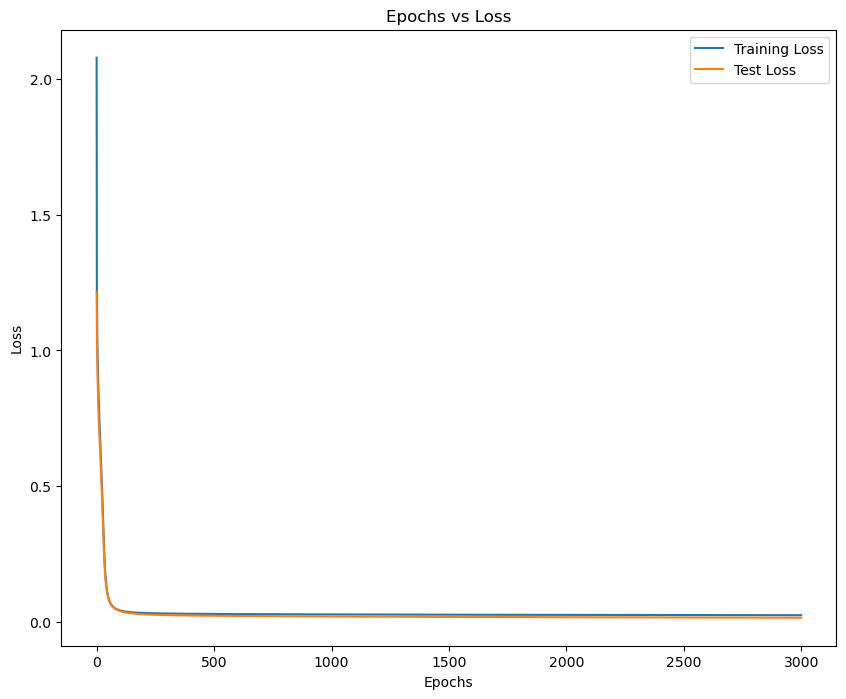

In [15]:
#Plot Loss Curve 
plt.figure(figsize=(10,8))
plt.plot(range(epochs),trainLossList,label = "Training Loss")
plt.plot(range(epochs),testLossList,label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend();